# EuroSat Imagery - EDA

In [1]:
%pip install altair vega_datasets
%pylab inline

# import gdal
import rasterio
import tensorflow as tf
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import altair as alt
import random

from tqdm import tqdm

Note: you may need to restart the kernel to use updated packages.
Populating the interactive namespace from numpy and matplotlib


Images in the dataset are in in Geotif format with all the bands (13) in the same file. The code below is an example of a patch labeled as "Industrial". Each band has 60x60 pixeles. In a visual inspection, we can note note that each image has the same covered area. The resolution varies for different bands. 

In [2]:
sr_path = '/workspace/app/data/raw/EuroSat/fulldata/'
# os.listdir(sr_path)

In [3]:
band_ds = rasterio.open(sr_path+'Forest/Forest_1000.tif')

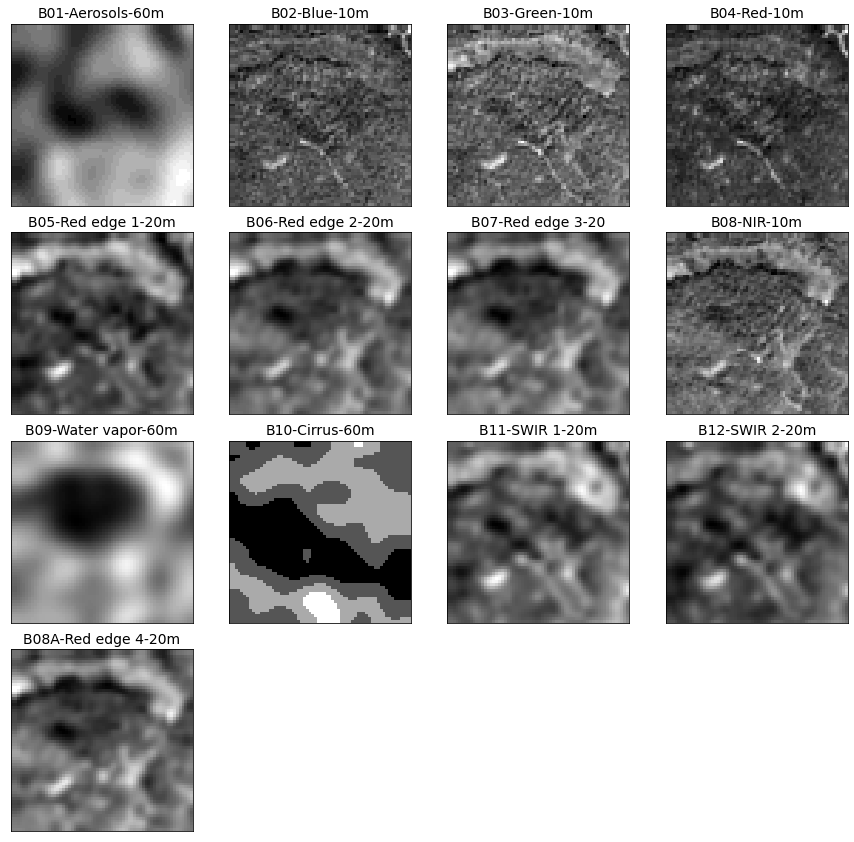

In [4]:
plt.figure(figsize=(15,15))

bands_l =['B01-Aerosols-60m','B02-Blue-10m','B03-Green-10m',
          'B04-Red-10m','B05-Red edge 1-20m','B06-Red edge 2-20m',
          'B07-Red edge 3-20','B08-NIR-10m','B09-Water vapor-60m',
          'B10-Cirrus-60m','B11-SWIR 1-20m','B12-SWIR 2-20m',
          'B08A-Red edge 4-20m']

for idx in range(13): # 13 bands
    raster_band = np.array(band_ds.read(idx+1))
    img1 = np.array(raster_band)

    plt.subplots_adjust(hspace=.1)
    plt.subplot(4,4,idx+1)
    plt.imshow(img1,interpolation='nearest',cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(bands_l[idx], fontsize=14)

## RGB Images

The data set has 10 different labels. Images are saved in different folders according to its label. Each folder has the name of the corresponding label. Here, we plot one example per each label considereing only the RGB (B04,B03,B02, Respectively).

In [5]:
base_path = '/workspace/app/data/raw/EuroSat/'
rgbpath = os.path.join(base_path,'rgbdata/')
labels = os.listdir(rgbpath)
print(labels)

['Pasture', 'Industrial', 'PermanentCrop', 'AnnualCrop', 'Highway', 'HerbaceousVegetation', 'Residential', 'Forest', 'River', 'SeaLake']


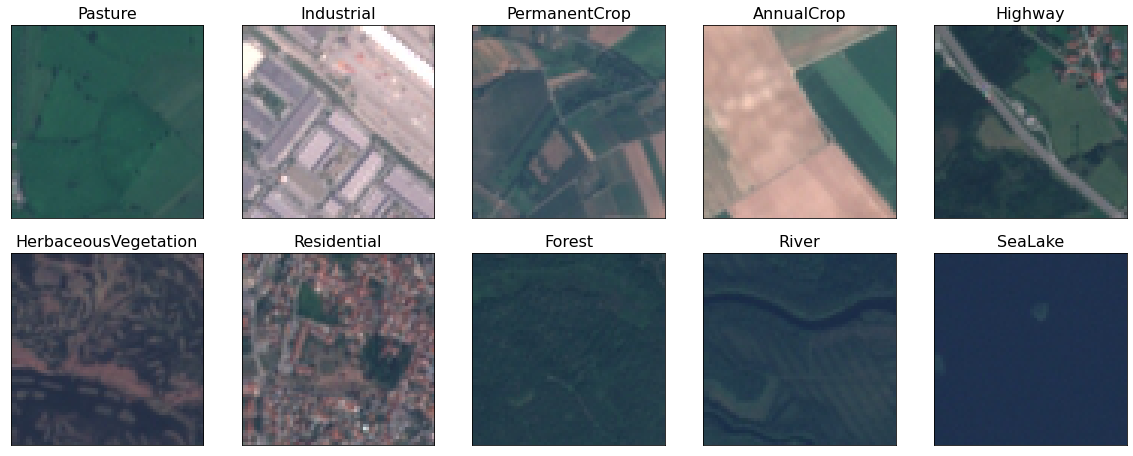

In [6]:
lcount={}

plt.figure(figsize=(20,8))

cont = 1
for lbl in labels:
  figpath = os.path.join(rgbpath,lbl+'/')
  lcount[lbl] = len(os.listdir(figpath))
  figname = figpath+lbl+'_1000.jpg'
  img2 = mpimg.imread(figname)

  plt.subplots_adjust(hspace=.1)
  plt.subplot(2,5,cont)

  imgplot = plt.imshow(img2)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(labels[cont-1], fontsize=16)
  cont = cont + 1

plt.show()

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

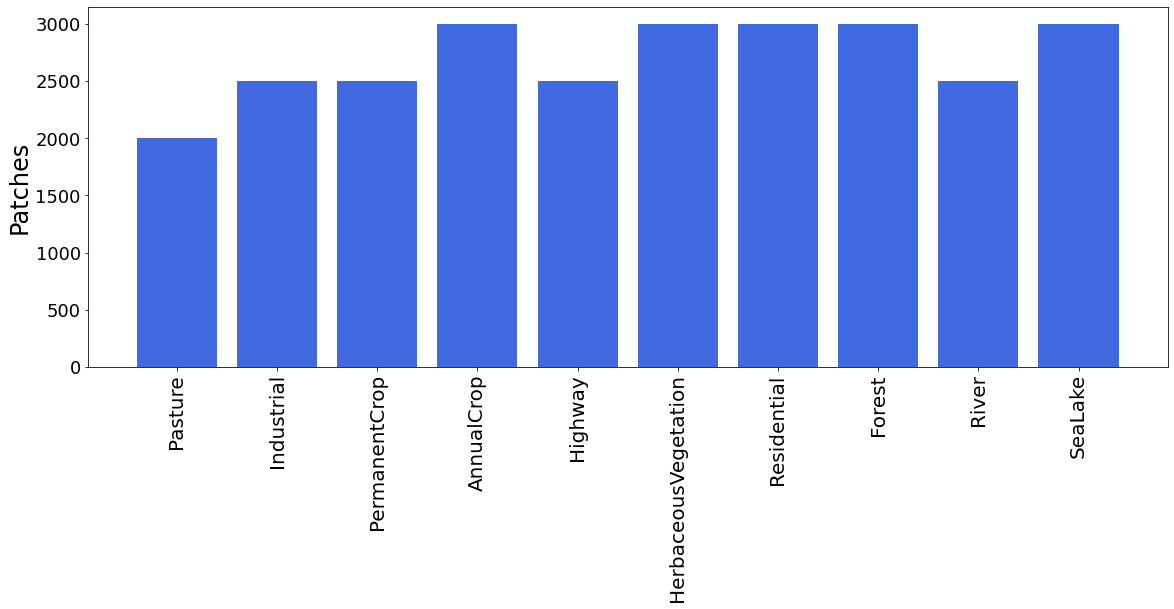

In [7]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
labels = lcount.keys()
count = lcount.values()
ax.bar(labels,count)

for bar in ax.patches:
    bar.set_facecolor('royalblue')
    
ax.set_ylabel('Patches',fontsize=24)
plt.xticks(rotation = 90,fontsize=20)
plt.yticks(fontsize=18)

In [8]:
bands_l2 =['B01','B02','B03','B04','B05','B06','B07','B08',
          'B09','B10','B11','B12','B8A']

In [9]:
cont = 0
label_list = os.listdir(sr_path)
label_list

['Pasture',
 'Industrial',
 'PermanentCrop',
 'AnnualCrop',
 'Highway',
 'HerbaceousVegetation',
 'Residential',
 'Forest',
 'River',
 'SeaLake']

In [10]:
nexamp = 100

df_mean = pd.DataFrame(columns=bands_l2)
df_mean['Label'] = None
df_mean['File'] = None
blist = list(df_mean.columns)
df_std = df_mean.copy()

new_mean={}
new_std={}
for i in blist:
    new_mean[i]=''
    new_std[i]=''
    
for lbl in label_list:
    print('\n {}'.format(lbl))
    label_path = os.path.join(sr_path,lbl)
    file_list = os.listdir(label_path)
    randomlist = random.sample(range(len(file_list)), nexamp)
    new_mean['Label']=lbl
    new_std['Label']=lbl
    file_list = [file_list[x] for x in randomlist]
    progress_bar = tf.keras.utils.Progbar(target = len(file_list))
    for findex,fin in enumerate(file_list):
        new_mean['File']=fin
        new_std['File']=fin
        band_ds = rasterio.open(os.path.join(label_path,fin))
        for idx in range(13): # 13 bands
            band_name = bands_l2[idx]
            raster_band = np.array(band_ds.read(idx+1))
            bidx = np.array(raster_band)
            new_mean[band_name]=bidx.mean()
            new_std[band_name]=bidx.std()           
        df_mean = df_mean.append(new_mean, ignore_index=True)
        df_std = df_std.append(new_std, ignore_index=True)
        progress_bar.update(findex)
        
df_dic = {}
for lbl in bands_l2:
    df_std2 = df_std[[lbl,'Label','File']].copy()
    df_std2 = df_std2.rename(columns={lbl: "std"})
    df_mean2 = df_mean[[lbl,'Label','File']].copy()
    df_mean2 = df_mean2.rename(columns={lbl: "mean"})

    df_dic[lbl] = pd.merge(df_mean2,df_std2,how='left',on=['File','Label'])
    df_dic[lbl].head()


 Pasture
 95/100 [===========================>..] - ETA: 0s
 Industrial
 95/100 [===========================>..] - ETA: 0s
 PermanentCrop
 95/100 [===========================>..] - ETA: 0s
 AnnualCrop
 95/100 [===========================>..] - ETA: 0s
 Highway
 95/100 [===========================>..] - ETA: 0s
 HerbaceousVegetation
 95/100 [===========================>..] - ETA: 0s
 Residential
 95/100 [===========================>..] - ETA: 0s
 Forest
 95/100 [===========================>..] - ETA: 0s
 River
 95/100 [===========================>..] - ETA: 0s
 SeaLake
 95/100 [===========================>..] - ETA: 0s

In [11]:
figura={}
for band in bands_l2:
    figura[band] = alt.Chart(df_dic[band]).mark_circle(size=60).encode(
        x='std',
        y='mean',
        color='Label',
        opacity=alt.value(0.5),
    ).properties(
        title=band+' ('+str(nexamp)+' random examples per label)',
        width=600,
        height=400
    )

In [12]:
figura['B01']

alt.Chart(...)

In [13]:
figura['B02']

alt.Chart(...)

In [14]:
figura['B03']

alt.Chart(...)

In [15]:
figura['B04']

alt.Chart(...)

In [16]:
figura['B05']

alt.Chart(...)

In [17]:
figura['B06']

alt.Chart(...)

In [18]:
figura['B07']

alt.Chart(...)

In [19]:
figura['B08']

alt.Chart(...)

In [20]:
figura['B8A']

alt.Chart(...)

In [21]:
figura['B09']

alt.Chart(...)

In [22]:
figura['B10']

alt.Chart(...)

In [23]:
figura['B11']

alt.Chart(...)

In [24]:
figura['B12']

alt.Chart(...)